# Spatial Analysis

Visualize statistical findings.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# standard 
import sys
import warnings

# data science
import pandas as pd

# geospatial
import geopandas as gpd

# visualization
import seaborn as sns

# module
sys.path.append("../src/")
import viz, stats

In [3]:
warnings.filterwarnings('ignore')

### Data Read 

In [4]:
df = gpd.read_file("../data/processed.csv",
                   GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
df.head(1)

,field_1,hs_diploma_rate,vacancy_rate,median_hh_income,population,dci,geometry
0,0,0.36,0.0,250001.0,830.0,Prosperous,"POLYGON ((-77.07295 38.95507, -77.07273 38.954..."


## Spatial Autocorrelation Analysis

Spatial autocorrelation refers to the combination of two types of similarity: 
1. spatial similarity  
2. attribute similarity

These two similarities are combined to get an idea of how much a target feature changes over in a region with respect to itself (ie autocorrelation). The fundamental objective is to visualize and statistically quantify a relationship between the target feature and geography.  

In [5]:
target_feature = "median_hh_income" # using this feature for this example
df[target_feature] = df[target_feature].astype(float)

### Spatial Weights/Similarity

First I will calculate spatial similarity by using the queen contiguity weight in particular, which checks if an adjacency relationship exists between two polygons (if a pair shares an edge or vertex). 

In [6]:
spatial_weights = stats.get_spatial_weights(df)

### Target Feature Similarity (Spatial Lag)

Now that we have measured similarity with respect to the spatial region, we are ready to measure it with respect to the target feature. 

This is calculated (for each district $i$) as:
$y_{\text{lag }i} = \sum_j w_{i, j} y_j$

where $w_{i, j}$ is a matrix of the spatial weights (row-standardized if continuous) that we just calculated above.

Mathematically, this is the <b>weighted sum of neighboring-district target feature values</b>.

In [7]:
y = df[target_feature]

In [8]:
df["y_lag"] = stats.get_lagged_y(spatial_weights, y)

### Visualizing Baseline/Lagged Target Feature Values

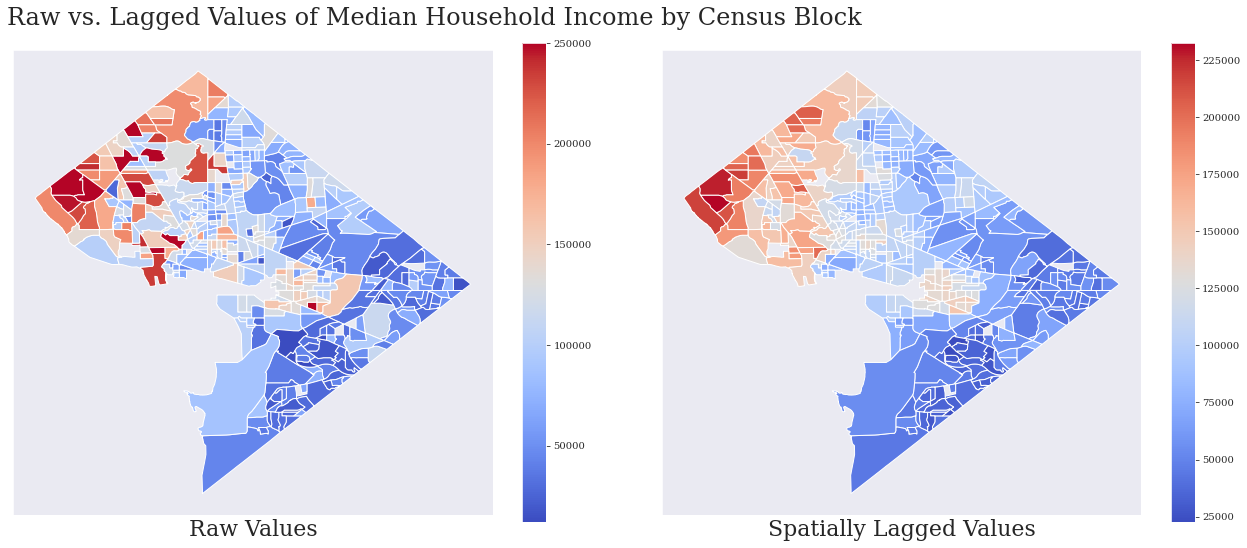

In [9]:
viz.lagged_feature(df, target_feature, df["y_lag"], "Median Household Income")

We should expect to see a change in the range (due to calculations when lagging the raw values) and a shift in the colors of some districts. It is expected that any high values (red in color) will 'spread' to the neighboring districts (think of it as ironing them out).  

### Statistically Comparing the Target with the Spatially Lagged Target

Above is a nice visual, but we still need to compare the two versions of the target (raw and spatially lagged) statistically to draw more reliable conclusions. 

To recap, we now have calculated the raw target values versus the weighted sum of the target with respect to each area's neighborhood (the lagged target values). To see if the geospatial aspect of this data affects the target variable distribution, we statistically compare these two versions of the target feature.

#### A Note on Population Size


When the target variable is a rate based on populations of different sizes, the Moran's I values need to be adjusted (during both global and local calculations). This is done in my code. 

#### Global Autocorrelation

To start, we compare the target feature over the scope of the entire map, with the ambition of discovering any geographical clusters that exist.

In this case, we have null hypothesis: 
- $H_0$: the data is completely spatially random (CSR)/no spatial autocorrelation. 

I will use Moran's I test to measure the correlation between a feature (raw target or lagged target) and the geographical space.

In [10]:
morans_i_test, _ = stats.moran_test(y, spatial_weights)

In [11]:
round(morans_i_test.I, 3) # the test statistic

0.61

This statistic $i \ \epsilon \ [-1, 1]$, where -1 is perfect dispersion (think of a chess board) and perfect separation (one half white, the other black, for example). A value of 0 is random.

##### Simulating

We will take a computational approach (I found multiple sources describing that, due to the variability in geographical structures, analytical approaches to spatial autocorrelation are very unreliable). 

Here we assume the target feature to be distributed CSR. We then calculate a Moran's I statistic, and build up a distribution of statistics by repeating this process. Then we see where our actual calculated statistic falls relative to this distribution to calculated a significance value respective to the CSR hypothesis. 

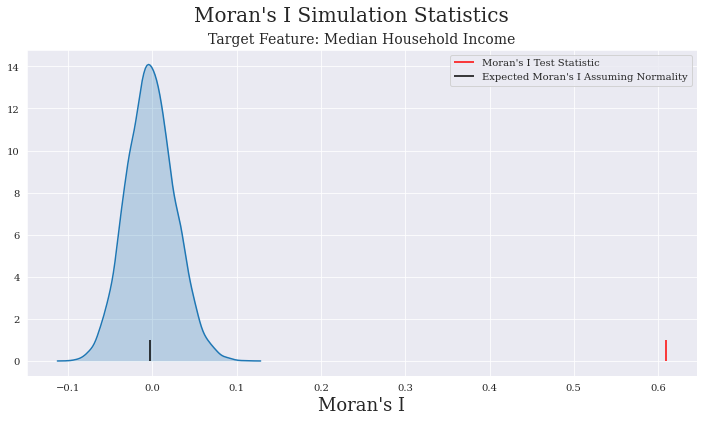

In [12]:
viz.moran_test_simulation(morans_i_test, target_feature_name="Median Household Income")

In [13]:
# The simulated p value (recalling the distribution above is simulated). 
morans_i_test.p_sim

0.0001

If we reject the null hypothesis/with a significant p-value, we can conclude the target feature distribution is not spatially random, and that there is a signficant spatial association relative to Dodoma region districts.

Recall this result applies to the map as a whole, as it is the <b>global</b> spatial autocorrelation. 

#### Local Autocorrelation

Whereas global autocorrelation can be interpreted as finding overall clustering of the target feature distribution relative to a region, the local autocorrelation looks to identify specific local clusters themselves. It is very similar to the above, only we perform a similar procedure over every individual geometric polygon (district) and get a significance measure for each. We can further put significant findings in context by turning to a local analysis where the attention shifts to detection of spatially correlated districts and spatial outliers.


Mathematically, the local Moran's I is simply the product of the target feature value and its spatial lag at a particular location (district). As a result, the global Moran's I we calculated above is the average rate of change of the local statistics. 


As before, here I take the computational approach (as the analytical is very unreliable for a small sample size like we have), which looks to use conditional permutations for each location. The conditional part here means I hold out the target feature observation at a particular location $i$ (to avoid additional spatial dependency), and then randomly shuffle the remaining values before computing the local Moran value. This builds up a simulated reference distribution, <b>which I do for each individual location</b>.

From here, we get determine if each district is locally significant in terms of the target feature distribution, relative to the other districts. To make this result more interpretable, I group findings according to the quadrant of the Moran's I scatterplot they come from; this is explained in much more detail below.


To recap and put this all in context, the main objective here is to identify specific areas in the region that are driving overall patterns observed in the target feature.

##### Moran's i Scatterplot

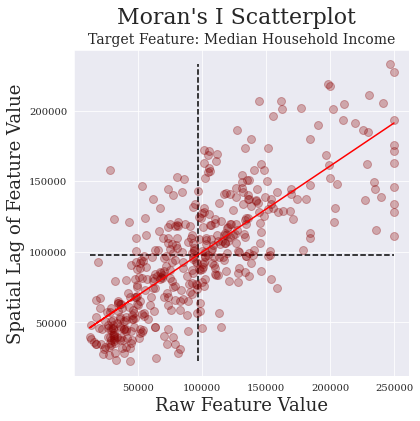

In [14]:
viz.morans_i_scatter(y, df["y_lag"], target_feature_name="Median Household Income")

The interpretation of the above is as follows:
We have essentially taken an array of local Moran's i statistics instead of a single global I like we did earlier (which would be the slope of the red regression line above).

By using the mean dividing lines of each axis (the raw feature value and spatially lagged feature values), we divide the two dimensional space into four quadrants. Each quadrant has a characteristic we may be interested in characterizing a district by:

- 1 <b>(top right)</b>:
    - there is a spatial association here (+, +)
    - points represent districts with high average target feature value surrounded by districts that also have high average
    - for simplicity, these will be referenced as 'diamond diamond'
- 2 <b>(top left)</b>: 
    - there is no spatial association here
    - points represent districts with low average target feature value, but surrounded by districts with high average
    - for simplicity, these will be referenced as 'rough in the diamonds'
- 3 <b>(bottom left)</b>:
    - there is a spatial association here (-, -)
    - points represent districts with low average target feature value surrounded by districts that also have a low average
    - for simplicity, these will be referenced as 'rough rough'
- 4 <b>(bottom right)</b>:
    - there is no spatial association here
    - points represent districts with high average target feature value, but are surrounded by districts with low average
    - for simplicity, these will be referenced as 'diamonds in the rough'
    
In technical terms, we can group these four quadrants into two supgroups:
1. spatial clusters: quadrants one and three, where there is a spatial correlation (positive or negative)
2. spatial outliers: quadrants two and four

### Doing this for all Target Features

Can calculate items over all features using the following code block:

In [15]:
# calculating moran's features for each feature of interest
df["population"] = df["population"].astype(float)
for feature in ["hs_diploma_rate", "vacancy_rate", "median_hh_income"]:
    df[feature] = df[feature].astype(float)
    df = stats.get_moran_features_for_col(df, feature, .05)

### Comparing Results with Custom DCI Metric

In [16]:
quad_col = target_feature+"_moran_quadrant_descriptive"
sig_df = df[df[quad_col]!="No Significance"][["dci", quad_col]]

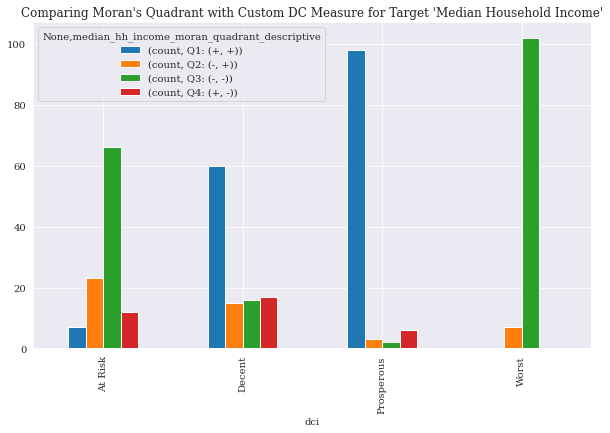

In [17]:
viz.dci_bar(sig_df, target_feature, "Median Household Income")

### Comparing Community Distress Metric with Moran's I Quadrant for Household Income

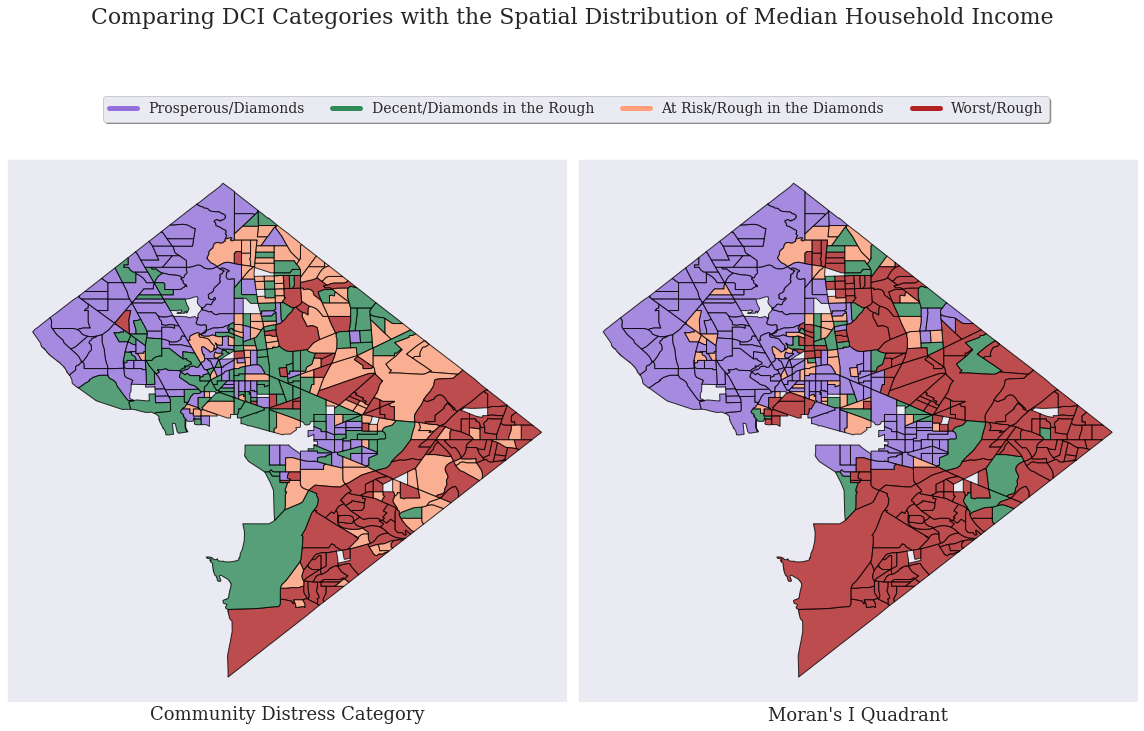

In [18]:
viz.compare_dci_quadrants(df, target_feature, "Median Household Income")